<a href="https://colab.research.google.com/github/ayulockin/interpretabilitycnn/blob/master/Visualize_Activations_W%26B_Way.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports, Installations and Setups

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG16

In [0]:
%%capture
!pip install wandb

In [3]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

True

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import cv2

# Download Cat and Dog Dataset

In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-27 16:04:50--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 2607:f8b0:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   189MB/s    in 0.3s    

2020-04-27 16:04:50 (189 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [7]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


# Prepare Dataset

In [8]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=20, 
                                   horizontal_flip=True, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1)

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Model

In [0]:
def catdogmodel():
  inputs = keras.layers.Input(shape=(150,150,3))
  x = keras.layers.Conv2D(32, (3,3), padding='valid')(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.activations.relu(x)
  x = keras.layers.Dropout(0.)(x)
  x = keras.layers.MaxPooling2D(2)(x)

  x = keras.layers.Conv2D(64, (3,3), padding='valid')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.activations.relu(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.MaxPooling2D(2)(x)

  x = keras.layers.Conv2D(128, (3,3), padding='valid')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.activations.relu(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.MaxPooling2D(2)(x)

  x = keras.layers.Flatten()(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(512, activation='relu')(x)
  x = keras.layers.Dense(64, activation='relu')(x)
  outputs = keras.layers.Dense(1, activation='sigmoid')(x)

  return keras.models.Model(inputs, outputs)

In [10]:
keras.backend.clear_session()
model = catdogmodel()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 32)      128       
_________________________________________________________________
tf_op_layer_Relu (TensorFlow [(None, 148, 148, 32)]    0         
_________________________________________________________________
dropout (Dropout)            (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496 

# Compile

In [0]:
model.compile('adam', 'binary_crossentropy', ['acc'])

# W&B Init and Callback

In [0]:
class FeaturesLogger(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, layer_name):
      '''
      validation_data: tuple of form (sample_images, sample_labels).
      layer_name: string of the layer of whose features we are interested in.
      '''
      super(FeaturesLogger, self).__init__()
      self.validation_data = validation_data
      self.layer_name = layer_name

    def on_epoch_end(self, logs, epoch):
    
      ## Initialize GetFeatures
      self.intermediate_model = keras.models.Model(inputs=model.input,
                                                   outputs=model.get_layer(self.layer_name).output)

      images, labels = self.validation_data

      for image, label in zip(images, labels):

        img = np.expand_dims(image, axis=0)
        features = self.intermediate_model.predict(img)
        
        features = features.reshape(features.shape[1:])
        features = np.rollaxis(features, 2, 0)
            
        fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(15,8))
        c = 0
        for i in range(4):
          for j in range(8):
            axs[i][j].imshow(features[c], cmap='gray')
            axs[i][j].set_xticks([])
            axs[i][j].set_yticks([])
            c+=1
        wandb.log({"features_labels_{}".format(label): plt})
        plt.close()

#### Prepare data for callback

In [13]:
## Prepare sample images.
sample_images, sample_labels = validation_generator[1]
sample_images.shape, sample_labels.shape

((20, 150, 150, 3), (20,))

In [0]:
## Get one image per class to visualize the activation. 
for_feature_images =[]
for_feature_labels = []

for idx, label in enumerate(sample_labels):
  if label==1.0:
    for_feature_images.append(sample_images[idx])
    for_feature_labels.append(label)
    break

for idx, label in enumerate(sample_labels):
  if label==0.0:
    for_feature_images.append(sample_images[idx])
    for_feature_labels.append(label)
    break

validation_data = for_feature_images, for_feature_labels

#### W&B Init

In [15]:
wandb.init(entity='ayush-thakur', project='interpretability')

W&B Run: https://app.wandb.ai/ayush-thakur/interpretability/runs/3r087jhj

# Train

In [16]:
history = model.fit(train_generator,
                    steps_per_epoch=300,
                    epochs=10,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=[WandbCallback(),
                               FeaturesLogger(validation_data, layer_name='conv2d')])

Epoch 1/10
300/300 [==============================] - 82s 272ms/step - loss: 1.1294 - acc: 0.5860 - val_loss: 0.6898 - val_acc: 0.5230
Epoch 2/10
300/300 [==============================] - 79s 265ms/step - loss: 0.6673 - acc: 0.5647 - val_loss: 0.6354 - val_acc: 0.6870
Epoch 3/10
300/300 [==============================] - 79s 264ms/step - loss: 0.5863 - acc: 0.6852 - val_loss: 0.5799 - val_acc: 0.6900
Epoch 4/10
300/300 [==============================] - 78s 262ms/step - loss: 0.5466 - acc: 0.7188 - val_loss: 0.6324 - val_acc: 0.6700
Epoch 5/10
300/300 [==============================] - 79s 265ms/step - loss: 0.5176 - acc: 0.7389 - val_loss: 0.5728 - val_acc: 0.7150
Epoch 6/10
300/300 [==============================] - 80s 265ms/step - loss: 0.4853 - acc: 0.7613 - val_loss: 0.5445 - val_acc: 0.7300
Epoch 7/10
300/300 [==============================] - 79s 263ms/step - loss: 0.4584 - acc: 0.7741 - val_loss: 0.5021 - val_acc: 0.7450
Epoch 8/10
300/300 [==============================] - 8

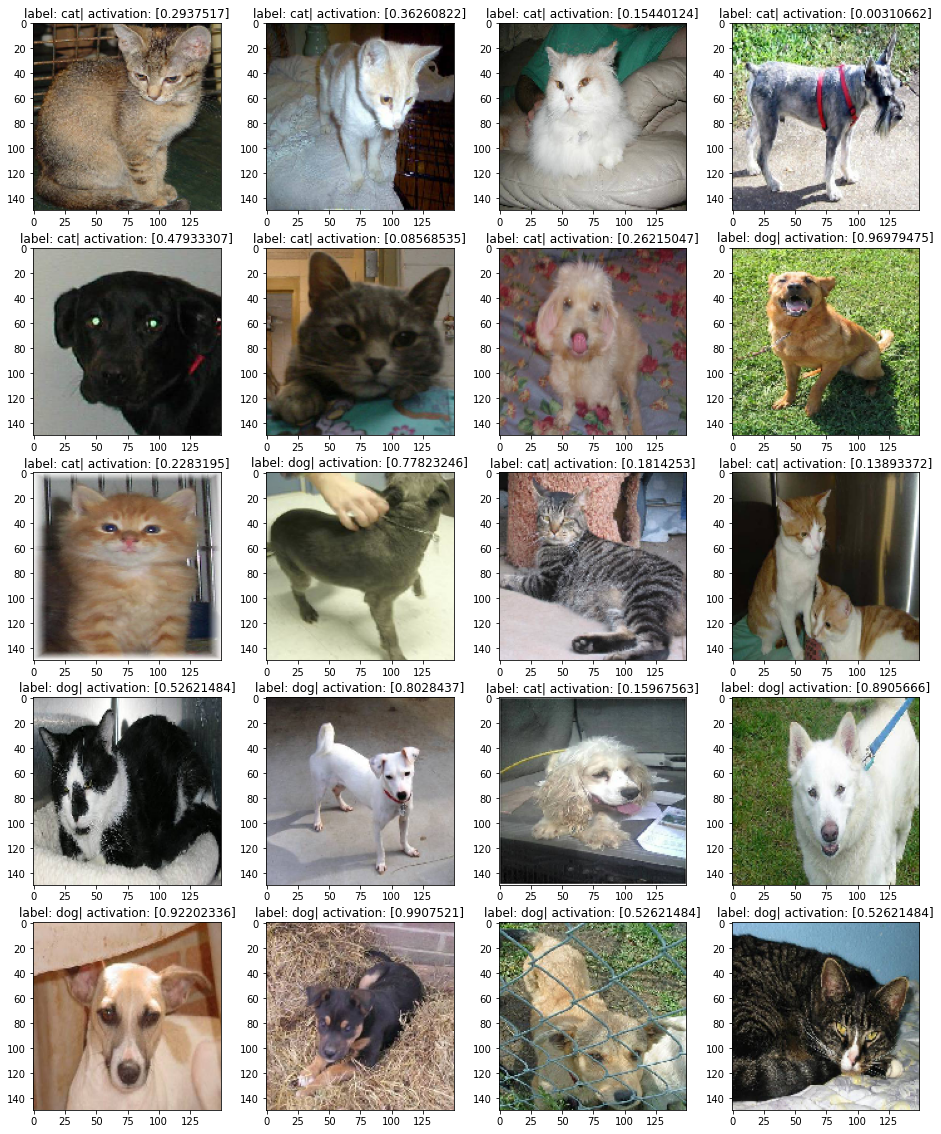

In [17]:
n_rows=len(sample_images)//4
n_cols=4 

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4*n_rows))

c = 0
for i in range(n_rows):
  for j in range(n_cols):
    image = np.expand_dims(sample_images[c], 0)
    pred = model.predict(image)
    if pred[0]>0.5:
      label='dog'
    else:
      label='cat'

    axs[i][j].imshow(sample_images[c]);
    axs[i][j].set_title('label: {}| activation: {}'.format(label, pred[0]));
    c+=1